# Implementation of VAE (Variational AutoEncoder)

*   VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
*   Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
*   Author-email:  mskang@handong.edu
*   python and pytorch version: python=3.7, pytorch=1.3.1 <br>

* [https://github.com/Jackson-Kang/Pytorch-VAE-tutorial?utm_source=chatgpt.com](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial?utm_source=chatgpt.com)


###    Step 0. Import libraries & Set Hyperparameters

In [1]:
# import libraries

import torch
import torch.nn as nn
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters 설정하기

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [23]:
# MNIST 데이터를 미니배치 단위로 업로드
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define model: VAE (Variational AutoEncoder)

In [4]:
# Gaussian MLP(다층 퍼셉트론) 기반 인코더 클래스 정의
# 입력 데이터를 정규분포의 평균과 로그분산으로 매핑해줌

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim) # 입력층 → 은닉층
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim) # 은닉층 → 은닉층
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim) # 은닉층 → 잠재 공간의 평균값 출력
        self.FC_var   = nn.Linear (hidden_dim, latent_dim) # 은닉층 → 잠재 공간의 로그 분산값 출력

        self.LeakyReLU = nn.LeakyReLU(0.2) # LeakyReLU 활성화 함수 사용

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x)) # 입력 x를 첫 번째 은닉층을 거쳐 활성화
        h_       = self.LeakyReLU(self.FC_input2(h_)) # 두 번째 은닉층을 거쳐 다시 활성화
        mean     = self.FC_mean(h_) # 평균값 계산
        log_var  = self.FC_var(h_) # 로그 분산값 계산
        # 인코더는 평균과 로그 분산을 출력
        # 이는 잠재 공간의 정규분포 q(z|x)의 파라미터로 사용됨

        return mean, log_var

In [5]:
# Gaussian MLP 기반 Decoder 클래스 정의
# 잠재공간(latent space)에서 샘플링된 z 값을 입력 받아 원래의 데이터 형상으로 복원

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)  # 잠재 벡터 → 첫 번째 은닉층
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim) # 첫 번째 은닉층 → 두 번째 은닉층
        self.FC_output = nn.Linear(hidden_dim, output_dim) # 두 번째 은닉층 → 출력층 (원래 데이터 차원으로 복원)

        self.LeakyReLU = nn.LeakyReLU(0.2) # LeakyReLU 활성화 함수 사용

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x)) # 잠재 벡터 x를 첫 번째 은닉층에 통과시키고 활성화 적용
        h     = self.LeakyReLU(self.FC_hidden2(h)) # 두 번째 은닉층에도 통과시켜 활성화 적용

        x_hat = torch.sigmoid(self.FC_output(h)) # 출력층에서 시그모이드 활성화 적용
        return x_hat # 재구성된 이미지 벡터 반환

In [6]:
# 전체 VAE 모델 정의
# Encoder와 Decoder를 연결하고, 중간에 reparameterization trick을 적용

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        # Encoder와 Decoder를 받아서 모델 구성
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        # 평균(mean)과 분산(var)을 이용해 잠재 변수 z를 샘플링
        # 정규분포에서 무작위 샘플 epsilon 생성 (평균 0, 분산 1)
        epsilon = torch.randn_like(var).to(DEVICE)      # sampling epsilon(var와 동일한 shape을 갖는 표준 정규분포 샘플)
        # reparameterization trick: z = μ + σ * ε→ backpropagation이 가능하게 함
        z = mean + var*epsilon
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x) # 인코더로부터 평균과 로그 분산 계산
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        # takes exponential function (log var -> var) 로그 분산을 표준 편차로 바꿈
        x_hat= self.Decoder(z) # 샘플링한 z를 디코더에 넣어 재구성된 x_hat 생성

        return x_hat, mean, log_var # 출력: 재구성 결과, 평균, 로그 분산

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reproduction_loss) and optimizer

In [24]:
from torch.optim import Adam

# VAE용 손실 함수 정의
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # 1. 재구성 손실 (입력 x와 복원된 x_hat 간의 차이)
    # 픽셀 값이 [0,1] 범위이므로 BCE를 사용
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    # 2. 정규화 손실 (KL divergence)
    # 인코더에서 추정한 정규분포 q(z|x)와 표준 정규분포 p(z) 사이의 차이를 최소화

    return reproduction_loss + KLD
    # 두 손실을 합친 최종 손실 반환 -> 최종손실 = 재구성 손실 + 정규화 손실

optimizer = Adam(model.parameters(), lr=lr)
# 모델 파라미터에 대해 Adam 옵티마이저 정의

### Step 4. Train VAE (Variational AutoEncoder)

In [9]:
print("Start training VAE...\n")
model.train()

# 전체 학습 epoch 반복
for epoch in range(epochs):
    overall_loss = 0 # 에폭마다 전체 손실을 누적할 변수 초기화

    # 미니배치 단위로 학습 데이터 반복
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad() # 이전 반복의 gradient 초기화

        x_hat, mean, log_var = model(x)
        # 모델 순전파 -> 복원된 이미지, 평균, 로그 분산 출력
        loss = loss_function(x, x_hat, mean, log_var)
        # 손실 함수 계산 (= 재구성 오차 + KL divergence)
        overall_loss += loss.item()
        # 전체 손실 누적 (평균 loss 계산을 위함)
        loss.backward() # 역전파로 gradient 계산
        optimizer.step() # optimizer를 통해 파라미터 업데이트

    # 에폭마다 평균 손실 출력
    print("\tEpoch", epoch + 1, "/", epochs, "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("\nFinish train")

Start training VAE...

	Epoch 1 / 30 	Average Loss:  174.1565858298988
	Epoch 2 / 30 	Average Loss:  128.0855797422788
	Epoch 3 / 30 	Average Loss:  116.7880142522694
	Epoch 4 / 30 	Average Loss:  112.81328173909641
	Epoch 5 / 30 	Average Loss:  110.27342706594324
	Epoch 6 / 30 	Average Loss:  108.66754535554048
	Epoch 7 / 30 	Average Loss:  107.43430324955655
	Epoch 8 / 30 	Average Loss:  106.33621000821682
	Epoch 9 / 30 	Average Loss:  105.5872862322621
	Epoch 10 / 30 	Average Loss:  104.97891767855279
	Epoch 11 / 30 	Average Loss:  104.45607751199917
	Epoch 12 / 30 	Average Loss:  103.97559242617905
	Epoch 13 / 30 	Average Loss:  103.49694319634287
	Epoch 14 / 30 	Average Loss:  103.13067925709515
	Epoch 15 / 30 	Average Loss:  102.74610933587229
	Epoch 16 / 30 	Average Loss:  102.50968505451794
	Epoch 17 / 30 	Average Loss:  102.27084929961394
	Epoch 18 / 30 	Average Loss:  101.95043598054049
	Epoch 19 / 30 	Average Loss:  101.74459201207742
	Epoch 20 / 30 	Average Loss:  101.60750

### Step 5. Generate images from test dataset

In [10]:
import matplotlib.pyplot as plt

In [11]:
model.eval()

# 평가 시에는 gradient를 계산하지 않도록 설정
with torch.no_grad():
    # 테스트용 데이터셋에서 첫 번째 배치만 가져오기
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x) # 학습된 모델로 복원된 이미지 생성
        # 첫 배치만 처리하고 반복 종료 (break)

        break

# 모델이 잘 학습되었는지 입력(x)과 복원 결과(x_hat)를 비교하기 위해
# 샘플 1개 배치만 추출하여 사용

In [12]:
# 하나의 이미지만 시각화하여 보여는 함수 정의
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

* x와 x_hat 비교

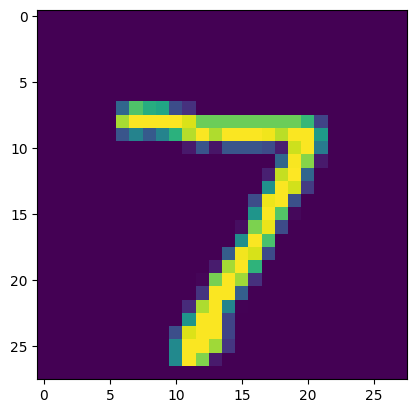

In [13]:
show_image(x, idx=0)

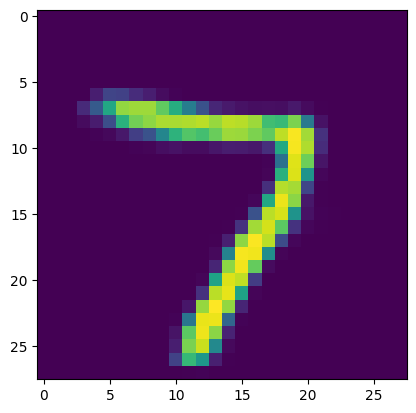

In [14]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
# VAE는 학습 과정에서 인코더가 추정하는 잠재 분포 q(z|x)를 표준 정규분포 N(0,1)에 가깝게 유도함
# (KL divergence 항을 통해 q(z|x)와 N(0,1)의 차이를 줄이도록 학습됨)

# 따라서 학습이 잘 되면, 인코더 없이도 z ∼ N(0,1)에서 샘플링한 z를 decoder에 넣는 것만으로도 이미지를 생성할 수 있음

# 이는 VAE의 원래 생성 경로(x -> encoder -> z -> decoder -> x_hat)는 아니지만,
# q(z|x)가 N(0,1)에 충분히 가까워졌는지를 확인하거나,
# VAE가 입력 없이도 새로운 데이터를 생성할 수 있다는 "생성 모델로서의 가능성"을 보여줌

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [16]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

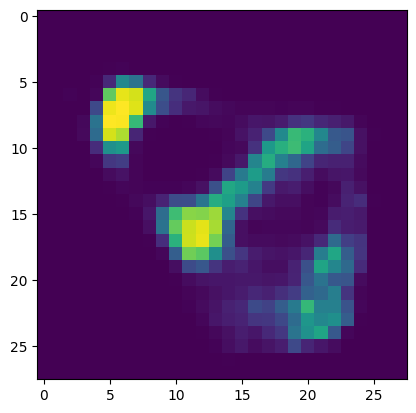

In [17]:
show_image(generated_images, idx=0)

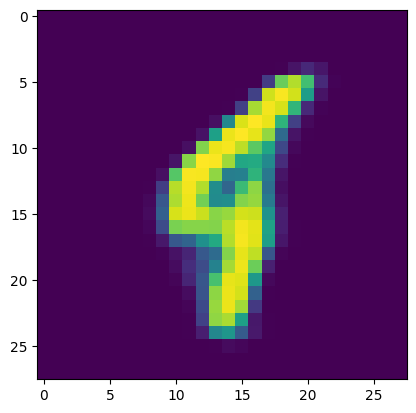

In [18]:
show_image(generated_images, idx=1)

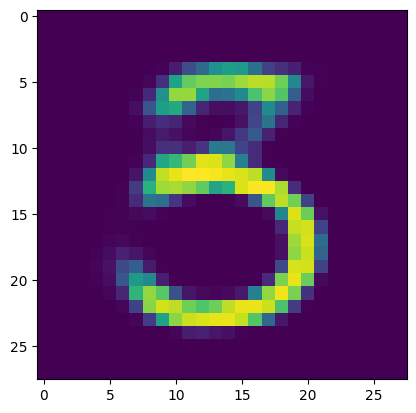

In [19]:
show_image(generated_images, idx=10)

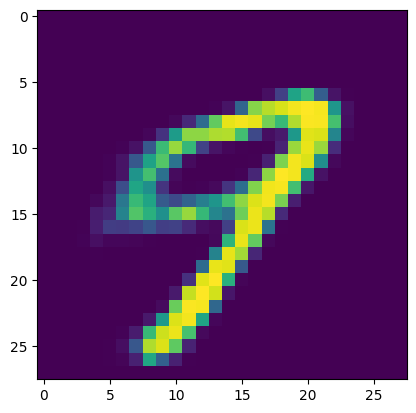

In [20]:
show_image(generated_images, idx=12)

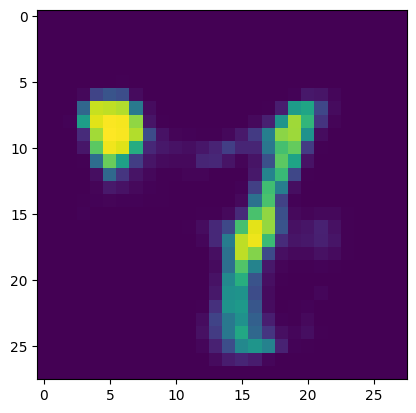

In [21]:
show_image(generated_images, idx=20)

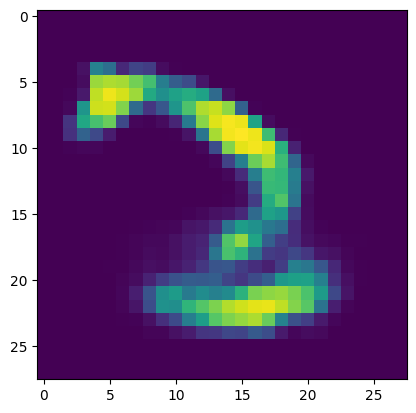

In [22]:
show_image(generated_images, idx=50)